In [29]:
from __future__ import print_function
import os
data_path = ['data']

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [30]:
filepath = os.sep.join(data_path + ['song_data.csv'])
data = pd.read_csv(filepath, sep=',')

In [31]:
#train, test set을 분리한다.
new_data = data.drop(['song_name'], axis = 1, inplace = False)

train, test = train_test_split(new_data, test_size=0.3, random_state=42)

In [32]:
#target column과 나머지를 분리한다.
target = 'song_popularity'
feature_cols = [x for x in train.columns if x != target]
X_train = train[feature_cols].to_numpy()
y_train = train[target].to_numpy()

X_test  = test[feature_cols].to_numpy()
y_test  = test[target].to_numpy()

In [33]:
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

In [34]:
#예측값과 실제값을 비교하여 plot하는 함수
def draw(actual, predict, label):
       f = plt.figure(figsize=(6,6))
       ax = plt.axes()

       ax.plot(actual, predict, 
              marker='o', ls='', ms=3.0)

       lim = (0, actual.max())

       ax.set(xlabel='Actual Song Popularity',
              ylabel='Predicted Song Popularity',
              xlim=lim,
              ylim=lim,
              title= label + ' Regression Results')

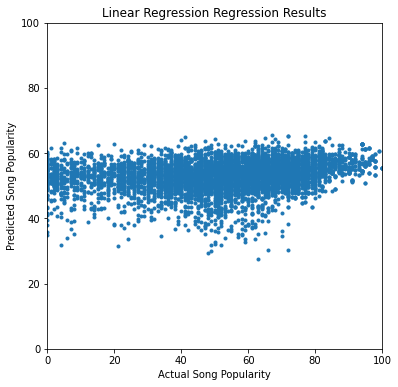

In [35]:
#일반 Linear Regression
linearRegression = LinearRegression().fit(X_train, y_train)

linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))

draw(y_test, linearRegression.predict(X_test), "Linear Regression")
# 0.8 sec


<class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>


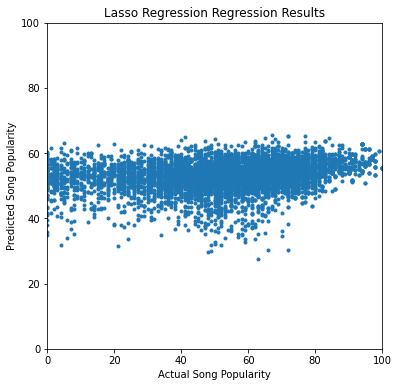

In [36]:
#일반 LassoCV Regression
alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=3).fit(X_train, y_train)

lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))

print(type(X_train), type(data))

draw(y_test, lassoCV.predict(X_test), "Lasso Regression")

In [37]:
rmse_vals = [linearRegression_rmse, lassoCV_rmse]

labels = ['Linear', 'Lasso']

rmse_df = pd.Series(rmse_vals, index=labels).to_frame()
rmse_df.rename(columns={0: 'RMSE'}, inplace=1)
rmse_df

,RMSE
Linear,21.476450
Lasso,21.476547


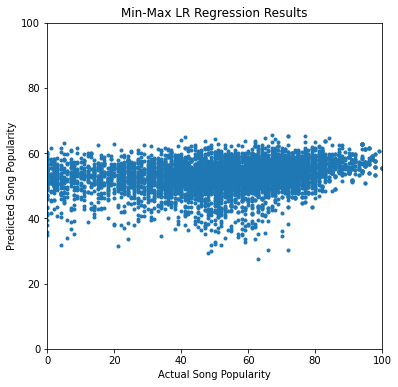

In [38]:
# Min-Max Scaler를 적용한 LR
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

new_rmses = {}
# following notation passes the dict items as arguments
linearRegression = LinearRegression().fit(X_train_scaled, y_train)

new_rmses['Linear'] = rmse(y_test, linearRegression.predict(X_test_scaled))

draw(y_test, linearRegression.predict(X_test_scaled), "Min-Max LR")

,RMSE,RMSE-MinMax
Linear,21.476450,21.476450
Lasso,21.476547,21.476877


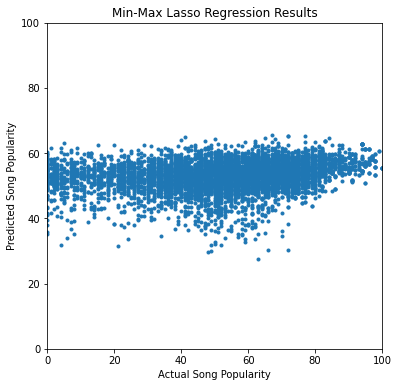

In [39]:
# Min-Max LassoCV
alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])
lassoCV = LassoCV(alphas=alphas2,
                max_iter=5e4,
                cv=3).fit(X_train_scaled, y_train)
new_rmses['Lasso'] = rmse(y_test, lassoCV.predict(X_test_scaled))

draw(y_test, lassoCV.predict(X_test_scaled), "Min-Max Lasso")

rmse_df['RMSE-MinMax'] = pd.Series(new_rmses)
rmse_df

,RMSE,RMSE-MinMax,RMSE-Standard
Linear,21.476450,21.476450,21.47645
Lasso,21.476547,21.476877,21.47645


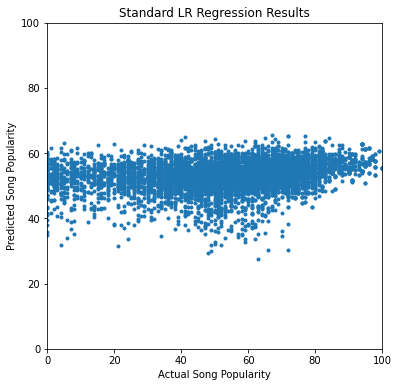

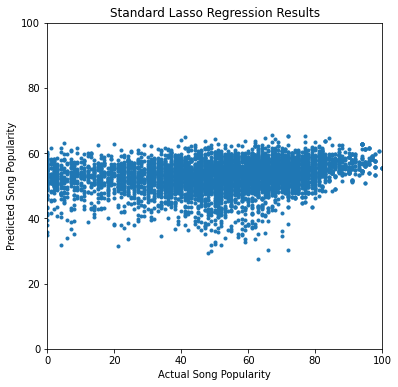

In [40]:
#Standard Scaler를 적용한 LR과 Lasso
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

new_rmses = {}
# following notation passes the dict items as arguments
linearRegression = LinearRegression().fit(X_train_scaled, y_train)

new_rmses['Linear'] = rmse(y_test, linearRegression.predict(X_test_scaled))

draw(y_test, linearRegression.predict(X_test_scaled), "Standard LR")

alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])
lassoCV = LassoCV(alphas=alphas2,
                max_iter=5e4,
                cv=10).fit(X_train_scaled, y_train)

new_rmses['Lasso'] = rmse(y_test, lassoCV.predict(X_test_scaled))

draw(y_test, lassoCV.predict(X_test_scaled), "Standard Lasso")

rmse_df['RMSE-Standard'] = pd.Series(new_rmses)
rmse_df

,RMSE,RMSE-MinMax,RMSE-Standard,RMSE-MinMax-SGD
Linear,21.476450,21.476450,21.47645,21.502255
Lasso,21.476547,21.476877,21.47645,21.502551


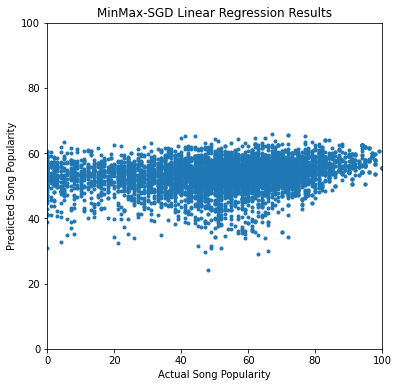

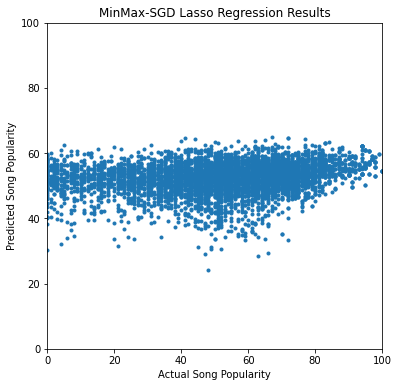

In [41]:
model_parameters_dict = {
    'Linear': {'penalty': 'none'},
    'Lasso': {'penalty': 'l2',
           'alpha': lassoCV.alpha_},
}

#Min Max Scaler를 적용한 LR SGD와 Lasso SGD
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train_scaled, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test_scaled))
    draw(y_test, SGD.predict(X_test_scaled), 'MinMax-SGD ' + modellabel)

rmse_df['RMSE-MinMax-SGD'] = pd.Series(new_rmses)
rmse_df

,RMSE,RMSE-MinMax,RMSE-Standard,RMSE-MinMax-SGD,RMSE-Standard-SGD
Linear,21.476450,21.476450,21.47645,21.502255,21.512426
Lasso,21.476547,21.476877,21.47645,21.502551,21.495823


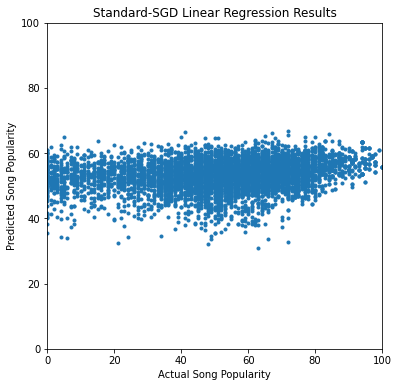

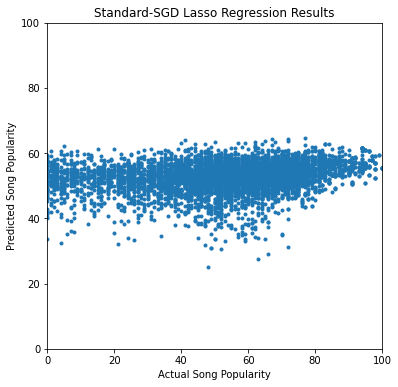

In [42]:
#Standard Scaler를 적용한 LR SGD와 Lasso SGD
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train_scaled, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test_scaled))
    draw(y_test, SGD.predict(X_test_scaled), 'Standard-SGD ' + modellabel)

rmse_df['RMSE-Standard-SGD'] = pd.Series(new_rmses)
rmse_df

#### 1) 실행 결과
- 최종적으로 Linear, Lasso Algorithm 과 각각의 Scaler 및 SGD를 적용에 따른 각각 결과는 위 표와 같다.
  
#### 2) Data 전처리
- Song data의 column 중 ‘song_name’ 은 regression 결과에 영향이 없을 것으로 판단하여 one-hot encoding 을 적용하는 대신 drop 하였다. 이외의 column 들은 전부 int 및 float형이기 때문에 추가적인 인코딩 없이 학습 및 테스트를 진행하였다. 훈련을 위한 데이터와 테스트를 위한 데이터의 비율은 7:3으로 설정하여 분할 하였다. 추가적으로  target column 인 ‘song_popularity’와 나머지 column 들을 분리하였다.이후 각각 모델 별, scaler 별, SGD 적용 유무 별로 test를 진행하여 rmse 값을 구하였다.

#### 3) 실행 시간
- 각각 적용하는데 걸리는 시간은 아래와 같다. 
 LR : 0.544s,   LR Min-Max : 0.001s,  LR Standard: 0.001s,  LR Min-Max SGD: 0.034s,  LR Standard SGD: 0.017s  
 Lasso : 0.001s, Lasso Min-Max : 0.051s,  Lasso Standard: 0.033s,  Lasso Min-Max SGD: 0.038s, Lasso Standard SGD: 0.018s 

#### 4) SGD 적용에 따른 실행시간과 RMSE 분석
- (실행시간 기준 더 나은 선택지)  위의 실행 시간에서 Lasso 기준으로 볼 때 SGD를 적용하지 않은 것이 확실히 빠른 실행시간을 보여주었다. 만약 데이터의 크기가 굉장히 크다면 SGD를 적용하는 것이 유리하다. 
- (RMSE(오차율) 기준 더 나은 선택지)  오차율 기준 SGD를 적용하지 않은 것이 Scaler에 관계 없이 더 나은 performance를 보여주었다.

- (실행시간과 RMSE 종합적으로 고려하여 어떤 선택을 해야 하는지)
현재 데이터(song_data.csv)를 기준으로 실행 시간을 비교하였을 때 SGD사용 유무에 따른 차이가 크지 않으므로, 데이터가 그리 크지 않다면 SGD를 사용하지 않는 편이 더 정확한 결과를 얻을 수 있다는 점에서 유리하다.  데이터의 크기가 크다면 Global Optima를 찾을 수 없는 가능성이 있더라도 SGD를 사용하여 시간 단축을 통해 얻을 수 있는 이점이 더 커진다는 점에서 사용하는 것이 유리하다.

#### 5) 결론
- 실험 데이터를 기준으로, LR, Lasso에 관계 없이 SGD를 사용하지 않고 Standard Scaler를 적용하면 최선의 결과를 보일 것으로 예상된다. 전반적인 결과를 보았을 때 해당 Data Set에는 Standard Scaler를 사용한 Linear Regression을 사용하는 것이 유리하고, 위 데이터는 크기가 크지 않았기 때문에(1초 이내) SGD를 적용하지 않고 오차율을 줄이는 것이 낫다는 결론을 내렸다.
- 더불어 미세한 차이였지만 SGD 적용유무에 따른 실행시간 차이, Scaler 별 오차율 차이가 있었으므로 각각의 데이터의 특성을 고려하여(데이터 크기 등)  각 데이터에 맞는 모델 선택이 중요할 것 같다.
